In [ ]:
# %%

import sys
import os
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import virga.justdoit as vj
import virga.justplotit as cldplt
import astropy.units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pickle
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
import xarray
from copy import deepcopy
from bokeh.plotting import show

#1 ck tables from roxana
mh = '+000'#'+0.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio

ck_db = f"../data/kcoeff_2020/sonora_2020_feh{mh}_co_{CtoO}.data.196"

#sonora bobcat cloud free structures file
sonora_profile_db = '../data/sonora_bobcat/structures_m+0.0'
sonora_dat_db = '../data/sonora_bobcat/structures_m+0.0'

cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

teff = 1500 # Effective Temperature of your Brown Dwarf in K
grav = 100 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities

nlevel = 91 # number of plane-parallel levels in your code
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.dat"),
                            usecols=[1,2],unpack=True, skiprows = 1)

nofczns = 1 # number of convective zones initially
nstr_upper = 60 # top most level of guessed convective zone
nstr_deep = nlevel - 2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,nstr_deep,0,0,0])
rfacv = 0.5 #we are focused on a brown dwarf so let's keep this as is

def twod_to_threed(arr, reps=4):
    """
    Takes in a 2D array of size (r, c) and repeats it along the last axis to make an array of size (r, c, reps).
    """
    return np.repeat(arr[:, :, np.newaxis], reps, axis=2)


print("Setting up atmosphere for cloudless run")
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv, cloudy = "cloudless", mh = '0.0', 
                      CtoO = '1.0',species = ['MgSiO3'], fsed = 1.0, beta = 0.1, virga_param = 'const',
                      mieff_dir = "~/projects/clouds/virga/refrind", do_holes = False, fhole = 0.5, fthin_cld = 0.9, moistgrad = False,
                      )

Setting up atmosphere for cloudless run


In [ ]:
# %%

out_cloudless = deepcopy(cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True))

In t_start: Converged Solution in iterations  2
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  740.2169191628859 0
In t_start: Converged Solution in iterations  2
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  700.3155184286907 1
In t_start: Converged Solution in iterations  2
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  737.3658005250744 2
In t_start: Converged Solution in iterations  2
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  697.894178484368 3
In t_start: Converged Solution in iterations  2
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  740.2841756188338 4
In t_start: Converged Solution in iterations  2
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  693.8785997720225 5
In t_start: Converged Solution in iterations  2
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  744.2763772163474 6
Not converged
 We are already at a root, tolf , test =  5e-05 ,  2.517213298650673e-05
Max 

In [ ]:
# %%

# Restart in order to make a postprocessed/fixed cloud profile
bundle = jdi.inputs(calculation='brown')
bundle.phase_angle(0)
bundle.gravity(gravity=grav, gravity_unit=u.Unit('m/s**2'))
temp, pressure = out_cloudless["temperature"], out_cloudless["pressure"]
bundle.add_pt(temp, pressure)
bundle.premix_atmosphere(opacity_ck, df = bundle.inputs['atmosphere']['profile'].loc[:,['pressure','temperature']])
DTAU, TAU, W0, COSB,ftau_cld, ftau_ray,GCOS2, DTAU_OG, TAU_OG, W0_OG, COSB_OG, \
                    W0_no_raman, surf_reflect, ubar0,ubar1,cos_theta, single_phase,multi_phase, \
                    frac_a,frac_b,frac_c,constant_back,constant_forward, \
                    wno,nwno,ng,nt, nlevel, ngauss, gauss_wts, mmw, gweight,tweight = jdi.calculate_atm(bundle, opacity_ck)
bb, y2, tp = 0, 0, 0
FOPI = np.zeros(opacity_ck.nwno) + 1.0
Teff = cl_run.inputs["planet"]["T_eff"]
min_temp = min(opacity_ck.temps)
max_temp = max(opacity_ck.temps)
if Teff > 300:
    tmin = min_temp
else:
    tmin = 10
tmax = max_temp*(1.3)
dt = bundle.inputs['climate']['dt_bb_grid']
ntmps = int((tmax-tmin)/dt)
flux_net_v_layer_full, flux_net_v_full, flux_plus_v_full, flux_minus_v_full , flux_net_ir_layer_full, flux_net_ir_full, flux_plus_ir_full, flux_minus_ir_full = jdi.get_fluxes(pressure, temp, opacity_ck.delta_wno, bb , y2, tp, tmin, tmax, DTAU, TAU, W0, 
                    COSB,ftau_cld, ftau_ray,GCOS2, DTAU_OG, TAU_OG, W0_OG, COSB_OG, W0_no_raman, surf_reflect, 
                    ubar0,ubar1,cos_theta, FOPI, single_phase,multi_phase,frac_a,frac_b,frac_c,constant_back,constant_forward, 
                    wno,nwno,ng,nt,gweight,tweight, nlevel, ngauss, gauss_wts,True, True)#True for reflected, True for thermal
mean_molecular_weight = np.mean(mmw)
sigma_sb = 0.56687e-4
tidal = np.zeros_like(pressure) - sigma_sb *(Teff**4)
grad = bundle.inputs["climate"]["grad"]
cp = bundle.inputs['climate']['cp']
nstr = out_cloudless["cvz_locs"]
kzz = jdi.get_kzz(
    out_cloudless["pressure"], out_cloudless["temperature"],grav,mmw,tidal,flux_net_ir_layer_full, flux_net_ir_layer_full,
    cl_run.inputs["climate"]["t_table"], cl_run.inputs["climate"]["p_table"], cl_run.inputs["climate"]["grad"], cl_run.inputs["climate"]["cp"],
    0,list(nstr),bundle.inputs['atmosphere']['profile'].T.values
)
# this virga run will use the cloudless-converged temperature profile
# and the associated Kzz
bundle.inputs['atmosphere']['profile']['temperature'] = temp
bundle.inputs['atmosphere']['profile']['kz'] = kzz

print("Making clouds off cloudless run for post-processed/fixed")
postproc_cld_out = bundle.virga(["MgSiO3"],"~/projects/clouds/virga/refrind", fsed=8.0,mh=1.0,mmw = mean_molecular_weight, b = 0.1, param = 'const')
postproc_cld_df = vj.picaso_format(postproc_cld_out["opd_per_layer"], postproc_cld_out["single_scattering"], postproc_cld_out["asymmetry"], postproc_cld_out["pressure"], 1e4 / postproc_cld_out["wave"])

Making clouds off cloudless run for post-processed/fixed


In [ ]:
# %%

cl_run.inputs["climate"]["cloudy"] = "fixed"
cl_run.inputs["climate"]["opd_climate"] = twod_to_threed(postproc_cld_out["opd_per_layer"])
cl_run.inputs["climate"]["w0_climate"] = twod_to_threed(postproc_cld_out["single_scattering"])
cl_run.inputs["climate"]["g0_climate"] = twod_to_threed(postproc_cld_out["asymmetry"])

In [ ]:
# %%

print("Fixed run")
out_fixed = deepcopy(cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True))

Fixed run
 We are already at a root, tolf , test =  5e-05 ,  4.591373851108808e-05
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  680.9666954617172 0
In t_start: Converged Solution in iterations  3
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  758.64872295302 1
 We are already at a root, tolf , test =  5e-05 ,  4.316301328006813e-05
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  685.9808040194383 2
In t_start: Converged Solution in iterations  3
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  758.7603168986916 3
 We are already at a root, tolf , test =  5e-05 ,  3.75308534933171e-05
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  686.7981521625114 4
In t_start: Converged Solution in iterations  3
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  758.3500548018417 5
 We are already at a root, tolf , test =  5e-05 ,  4.561511124541616e-05
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  687

In [ ]:
# %%

cl_run.inputs["climate"]["opd_climate"] = 100 * twod_to_threed(postproc_cld_out["opd_per_layer"])
out_fixed100 = deepcopy(cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True))

In t_start: Converged Solution in iterations  3
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  753.7839889106278 0
In t_start: Converged Solution in iterations  3
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  755.6413216236393 1
In t_start: Converged Solution in iterations  2
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  747.0141775616585 2
In t_start: Converged Solution in iterations  2
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  763.0272400436281 3
In t_start: Converged Solution in iterations  2
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  742.5321382559779 4
 We are already at a root, tolf , test =  5e-05 ,  3.815951404965365e-05
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  767.9324543838495 5
In t_start: Converged Solution in iterations  2
Max TAUCLD diff is 0.0  Tau tolerance is  1
Big iteration is  740.9654072570352 6
Not converged
 We are already at a root, tolf , test =  5e-05 ,  

In [ ]:
# %%

print("Self-consistent run")
cl_run.inputs_climate(temp_guess=deepcopy(out_fixed["temperature"]), pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv, cloudy = "selfconsistent", mh = '0.0', 
                      CtoO = '1.0',species = ['MgSiO3'], fsed = 8.0, beta = 0.1, virga_param = 'const',
                      mieff_dir = "~/projects/clouds/virga/refrind", do_holes = False, fhole = 0.5, fthin_cld = 0.9, moistgrad = False,
                      )
cl_run.inputs["climate"]["guess_temp"][np.isnan(out_fixed["temperature"])] = out_fixed["temperature"][0]

out_selfconsistent = deepcopy(cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True))

Self-consistent run
Cloudy functionality still in beta form and not ready for public use.
In t_start: Converged Solution in iterations  3
Max TAUCLD diff is 0.0  Tau tolerance is  0.020967569115213754
Big iteration is  753.7839889106278 0
In t_start: Converged Solution in iterations  3
Max TAUCLD diff is 0.0  Tau tolerance is  0.06725435021113735
Big iteration is  686.503338089025 1
In t_start: Converged Solution in iterations  3
Max TAUCLD diff is 0.0  Tau tolerance is  0.10785767308861996
Big iteration is  762.3868079840663 2
In t_start: Converged Solution in iterations  3
Max TAUCLD diff is 0.0  Tau tolerance is  0.15875505114771393
Big iteration is  696.4340173892338 3
In t_start: Converged Solution in iterations  3
Max TAUCLD diff is 0.0  Tau tolerance is  0.17704440162472837
Big iteration is  771.5425925530654 4
In t_start: Converged Solution in iterations  3
Max TAUCLD diff is 0.0  Tau tolerance is  0.1893481010557805
Big iteration is  705.0632434217217 5
In t_start: Converged S

In [ ]:
# %%

plt.rcParams['figure.dpi'] = 300
for (out, cld_out, run_name) in zip(
    [out_cloudless, out_cloudless, out_fixed, out_fixed100, out_selfconsistent],
    [None, postproc_cld_df, postproc_cld_df, postproc_cld_df100, out_selfconsistent['cld_output_picaso']],
    ["cloudless", "postprocessed", "fixed", "fixed100", "selfconsistent"]
):
    wno, fp = calculate_spectrum(out, cld_out)
    plt.loglog(1e4/wno, fp, label=run_name)
    np.save(f"../data/four_clouds_testing/wno_{run_name}.npy", wno)
    np.save(f"../data/four_clouds_testing/fp_{run_name}.npy", fp)

plt.xlabel("Wavelength (um)")
plt.ylabel("Flux (erg/cm^2/s/cm)")
plt.legend()
plt.show()

NameError: name 'postproc_cld_df100' is not defined

In [ ]:
# %% 

postproc_cld_df100 = deepcopy(postproc_cld_df)
postproc_cld_df100["opd"] *= 100

In [ ]:
# %%

plt.rcParams['figure.dpi'] = 300
for (out, cld_out, run_name) in zip(
    [out_cloudless, out_cloudless, out_fixed, out_fixed100, out_selfconsistent],
    [None, postproc_cld_df, postproc_cld_df, postproc_cld_df100, out_selfconsistent['cld_output_picaso']],
    ["cloudless", "postprocessed", "fixed", "fixed100", "selfconsistent"]
):
    wno, fp = calculate_spectrum(out, cld_out)
    plt.loglog(1e4/wno, fp, label=run_name)
    np.save(f"../data/four_clouds_testing/wno_{run_name}.npy", wno)
    np.save(f"../data/four_clouds_testing/fp_{run_name}.npy", fp)

plt.xlabel("Wavelength (um)")
plt.ylabel("Flux (erg/cm^2/s/cm)")
plt.legend()
plt.show()

NameError: name 'calculate_spectrum' is not defined

In [ ]:
# %%

def calculate_spectrum(out, cld_out):
    opa_mon = jdi.opannection()

    hi_res = jdi.inputs(calculation="browndwarf") # start a calculation
    grav = 316 # Gravity of your brown dwarf in m/s/s
    hi_res.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity

    hi_res.atmosphere(df=out['ptchem_df'])
    if cld_out is not None:
        hi_res.clouds(df=cld_out)

    df_spec1 = hi_res.spectrum(opa_mon, calculation='thermal', full_output= True)

    wno, fp = df_spec1['wavenumber'], df_spec1['thermal'] #erg/cm2/s/cm
    xmicron = 1e4/wno

    flamy = fp*1e-8  
    sp = jdi.psyn.ArraySpectrum(xmicron, flamy,
                            waveunits='um',
                            fluxunits='FLAM')
    sp.convert("um")
    sp.convert('Fnu')  # erg/cm2/s/Hz

    wno = sp.wave  # micron
    fp = sp.flux  # erg/cm2/s/Hz
    df_spec1['fluxnu'] = fp
    wno,fp = jdi.mean_regrid(1e4/wno,fp, R=200)
    return wno, fp

In [ ]:
# %%

def calculate_spectrum(out, cld_out):
    opa_mon = jdi.opannection()

    hi_res = jdi.inputs(calculation="browndwarf") # start a calculation
    grav = 316 # Gravity of your brown dwarf in m/s/s
    hi_res.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity

    hi_res.atmosphere(df=out['ptchem_df'])
    if cld_out is not None:
        hi_res.clouds(df=cld_out)

    df_spec1 = hi_res.spectrum(opa_mon, calculation='thermal', full_output= True)

    wno, fp = df_spec1['wavenumber'], df_spec1['thermal'] #erg/cm2/s/cm
    xmicron = 1e4/wno

    flamy = fp*1e-8  
    sp = jdi.psyn.ArraySpectrum(xmicron, flamy,
                            waveunits='um',
                            fluxunits='FLAM')
    sp.convert("um")
    sp.convert('Fnu')  # erg/cm2/s/cm

    wno = sp.wave  # micron
    fp = sp.flux  # erg/cm2/s/cm
    df_spec1['fluxnu'] = fp
    wno,fp = jdi.mean_regrid(1e4/wno,fp, R=200)
    return wno, fp

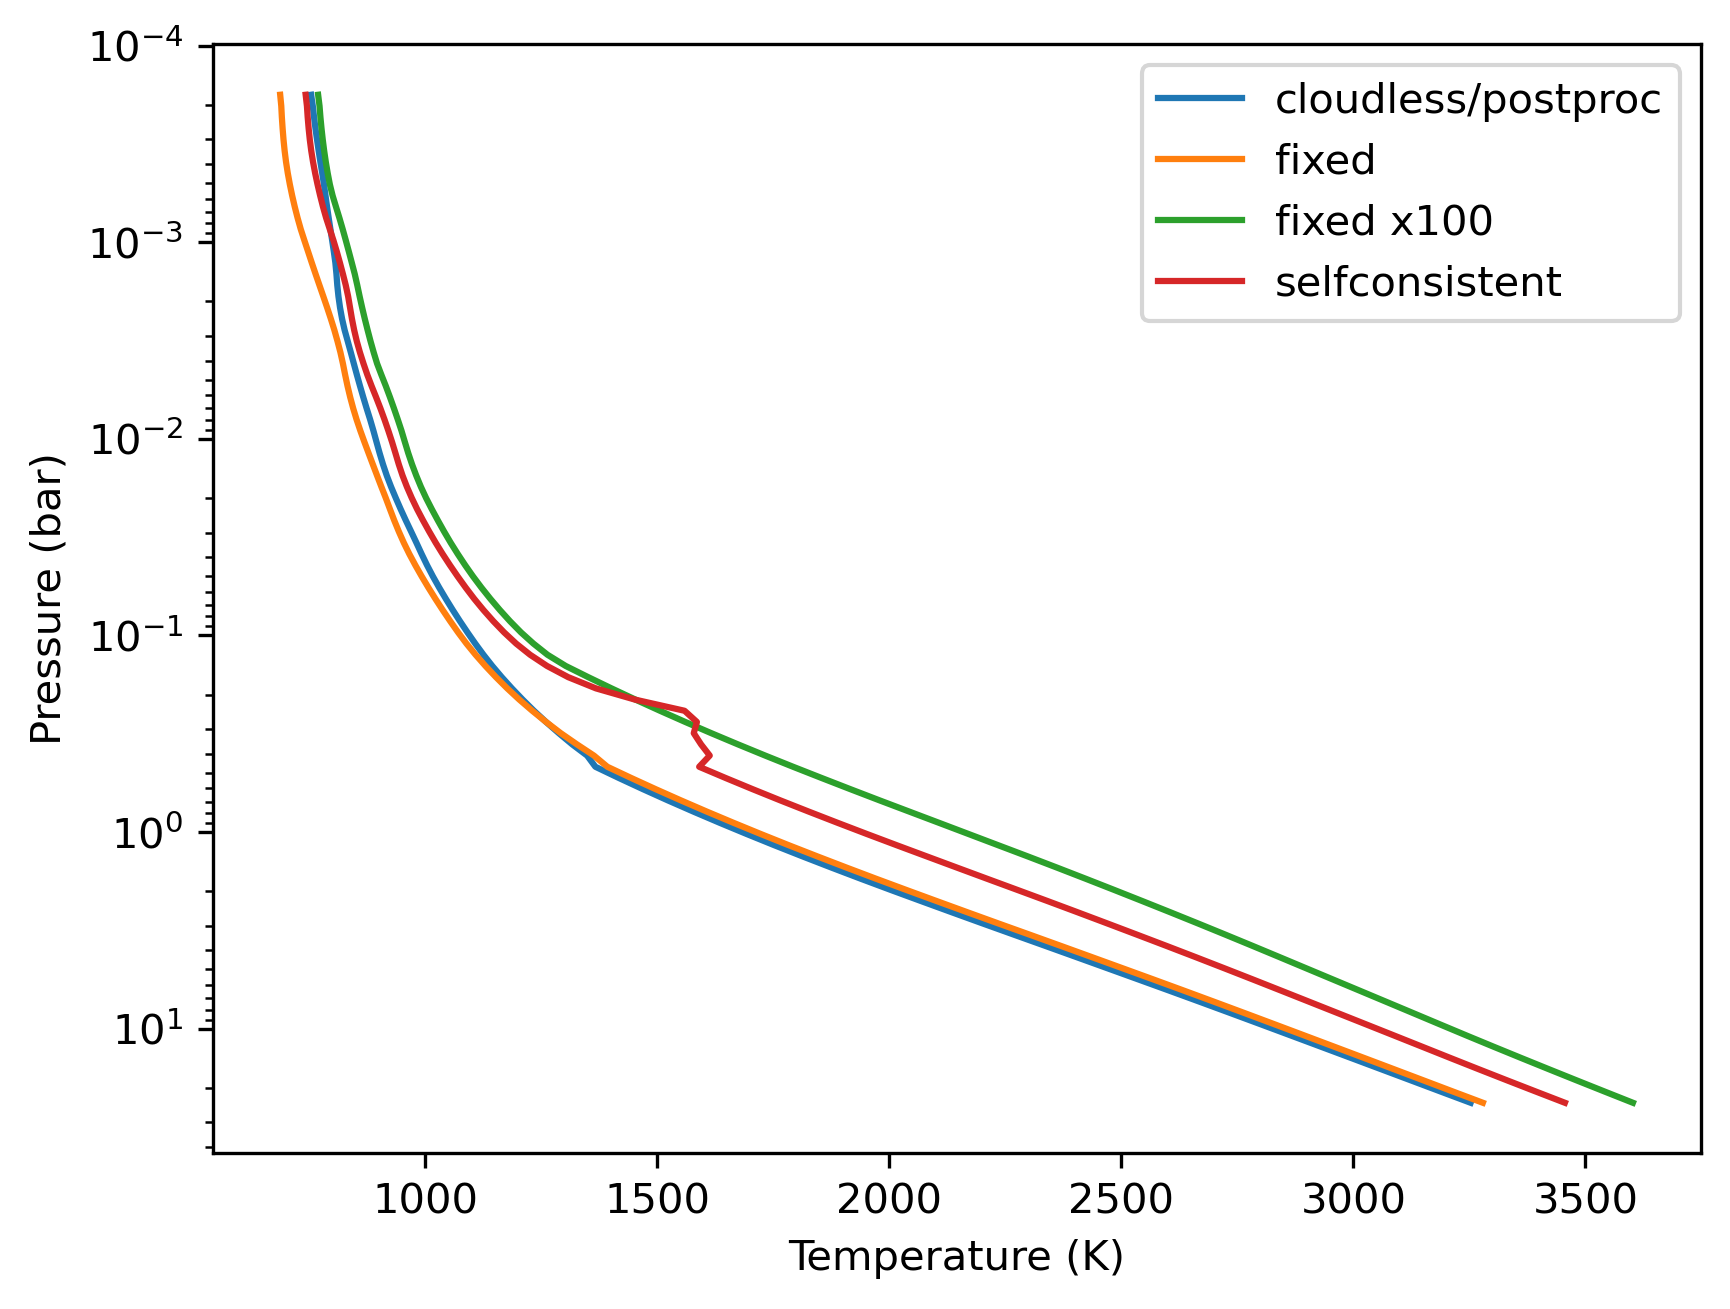

In [ ]:
# %%

for (out, run_name) in zip(
    [out_cloudless, out_fixed, out_fixed100, out_selfconsistent],
    ["cloudless/postproc", "fixed", "fixed x100", "selfconsistent"]
):
    plt.semilogy(out["temperature"], out["pressure"], label=run_name)
    
plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (bar)")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [ ]:
# %% 

postproc_cld_df100 = deepcopy(postproc_cld_df)
postproc_cld_df100["opd"] *= 100

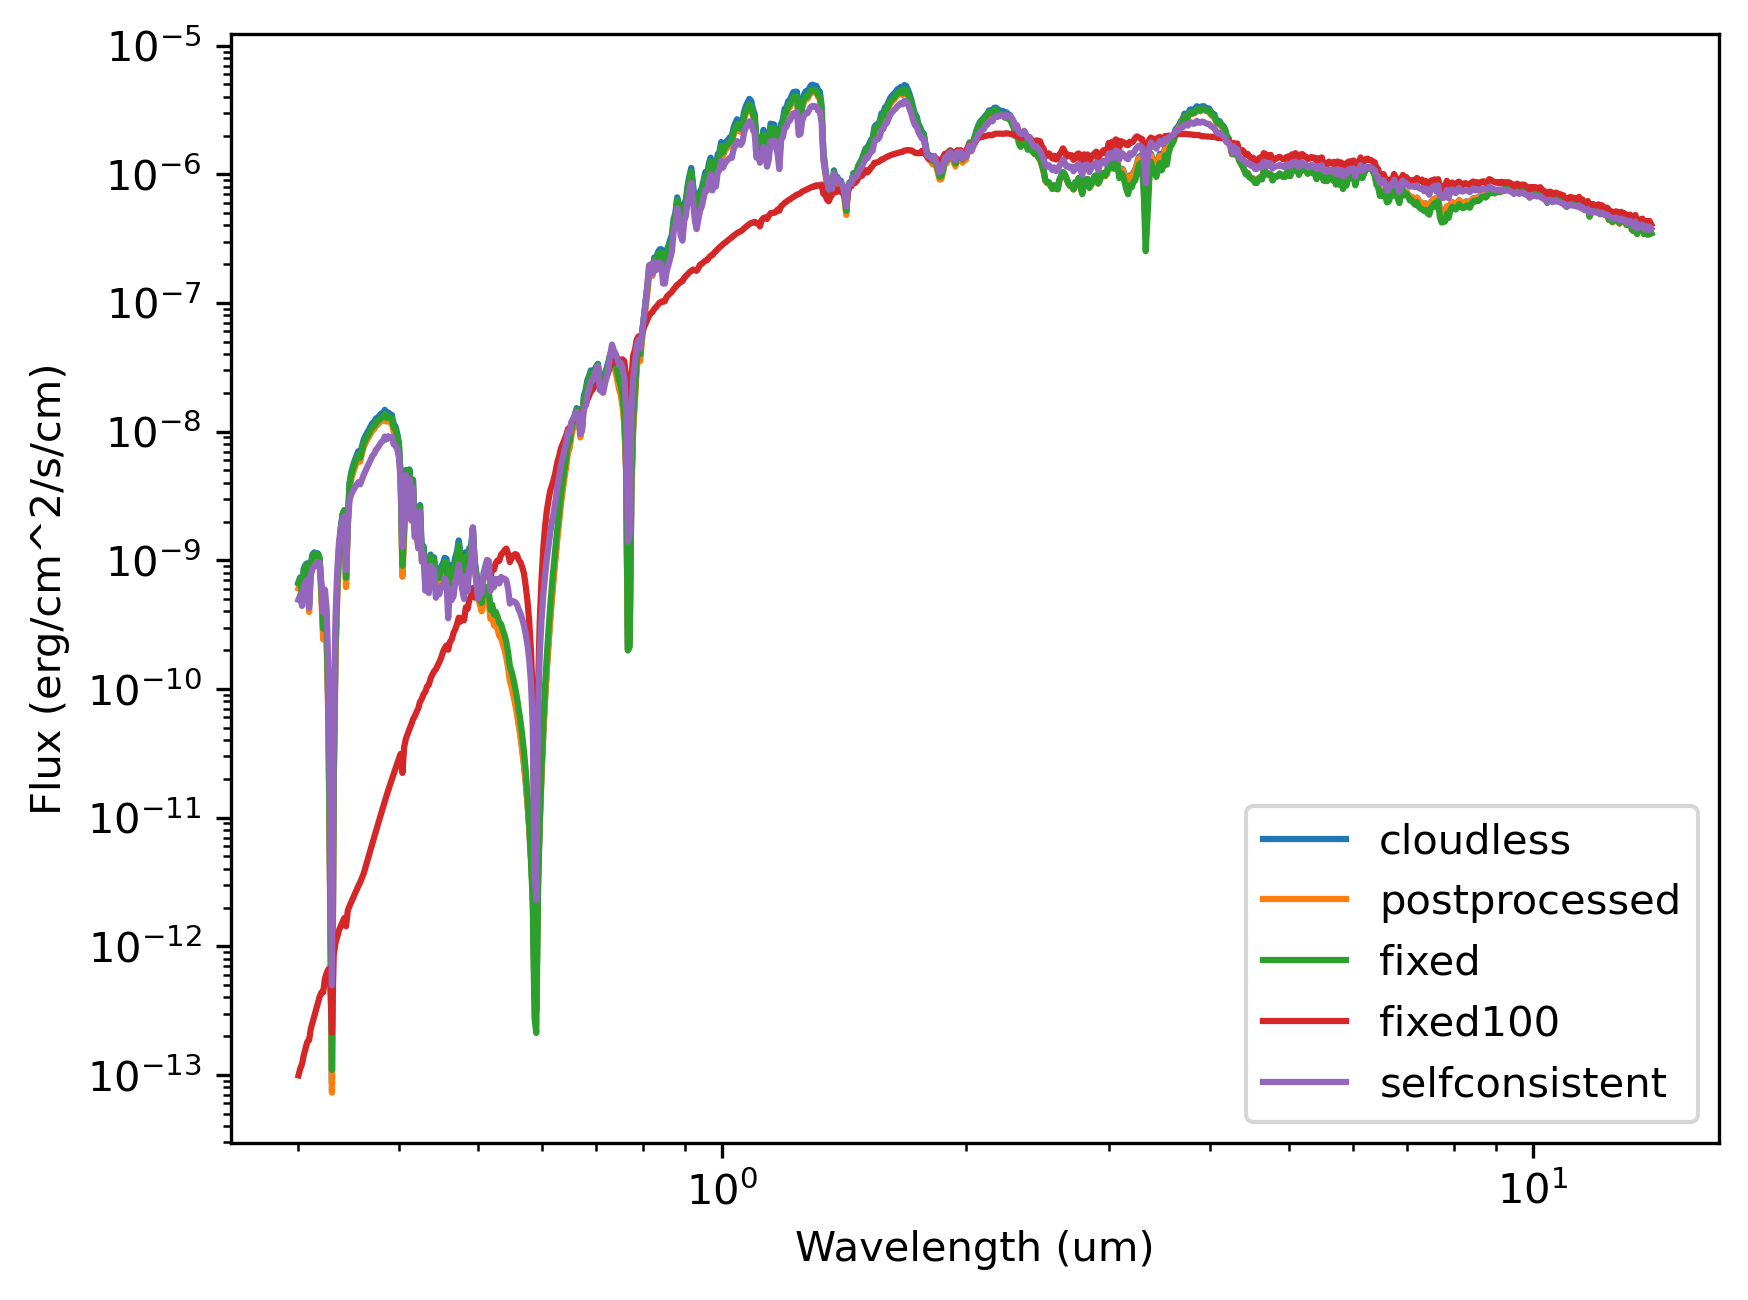

In [ ]:
# %%

plt.rcParams['figure.dpi'] = 300
for (out, cld_out, run_name) in zip(
    [out_cloudless, out_cloudless, out_fixed, out_fixed100, out_selfconsistent],
    [None, postproc_cld_df, postproc_cld_df, postproc_cld_df100, out_selfconsistent['cld_output_picaso']],
    ["cloudless", "postprocessed", "fixed", "fixed100", "selfconsistent"]
):
    wno, fp = calculate_spectrum(out, cld_out)
    plt.loglog(1e4/wno, fp, label=run_name)
    np.save(f"../data/four_clouds_testing/wno_{run_name}.npy", wno)
    np.save(f"../data/four_clouds_testing/fp_{run_name}.npy", fp)

plt.xlabel("Wavelength (um)")
plt.ylabel("Flux (erg/cm^2/s/cm)")
plt.legend()
plt.show()

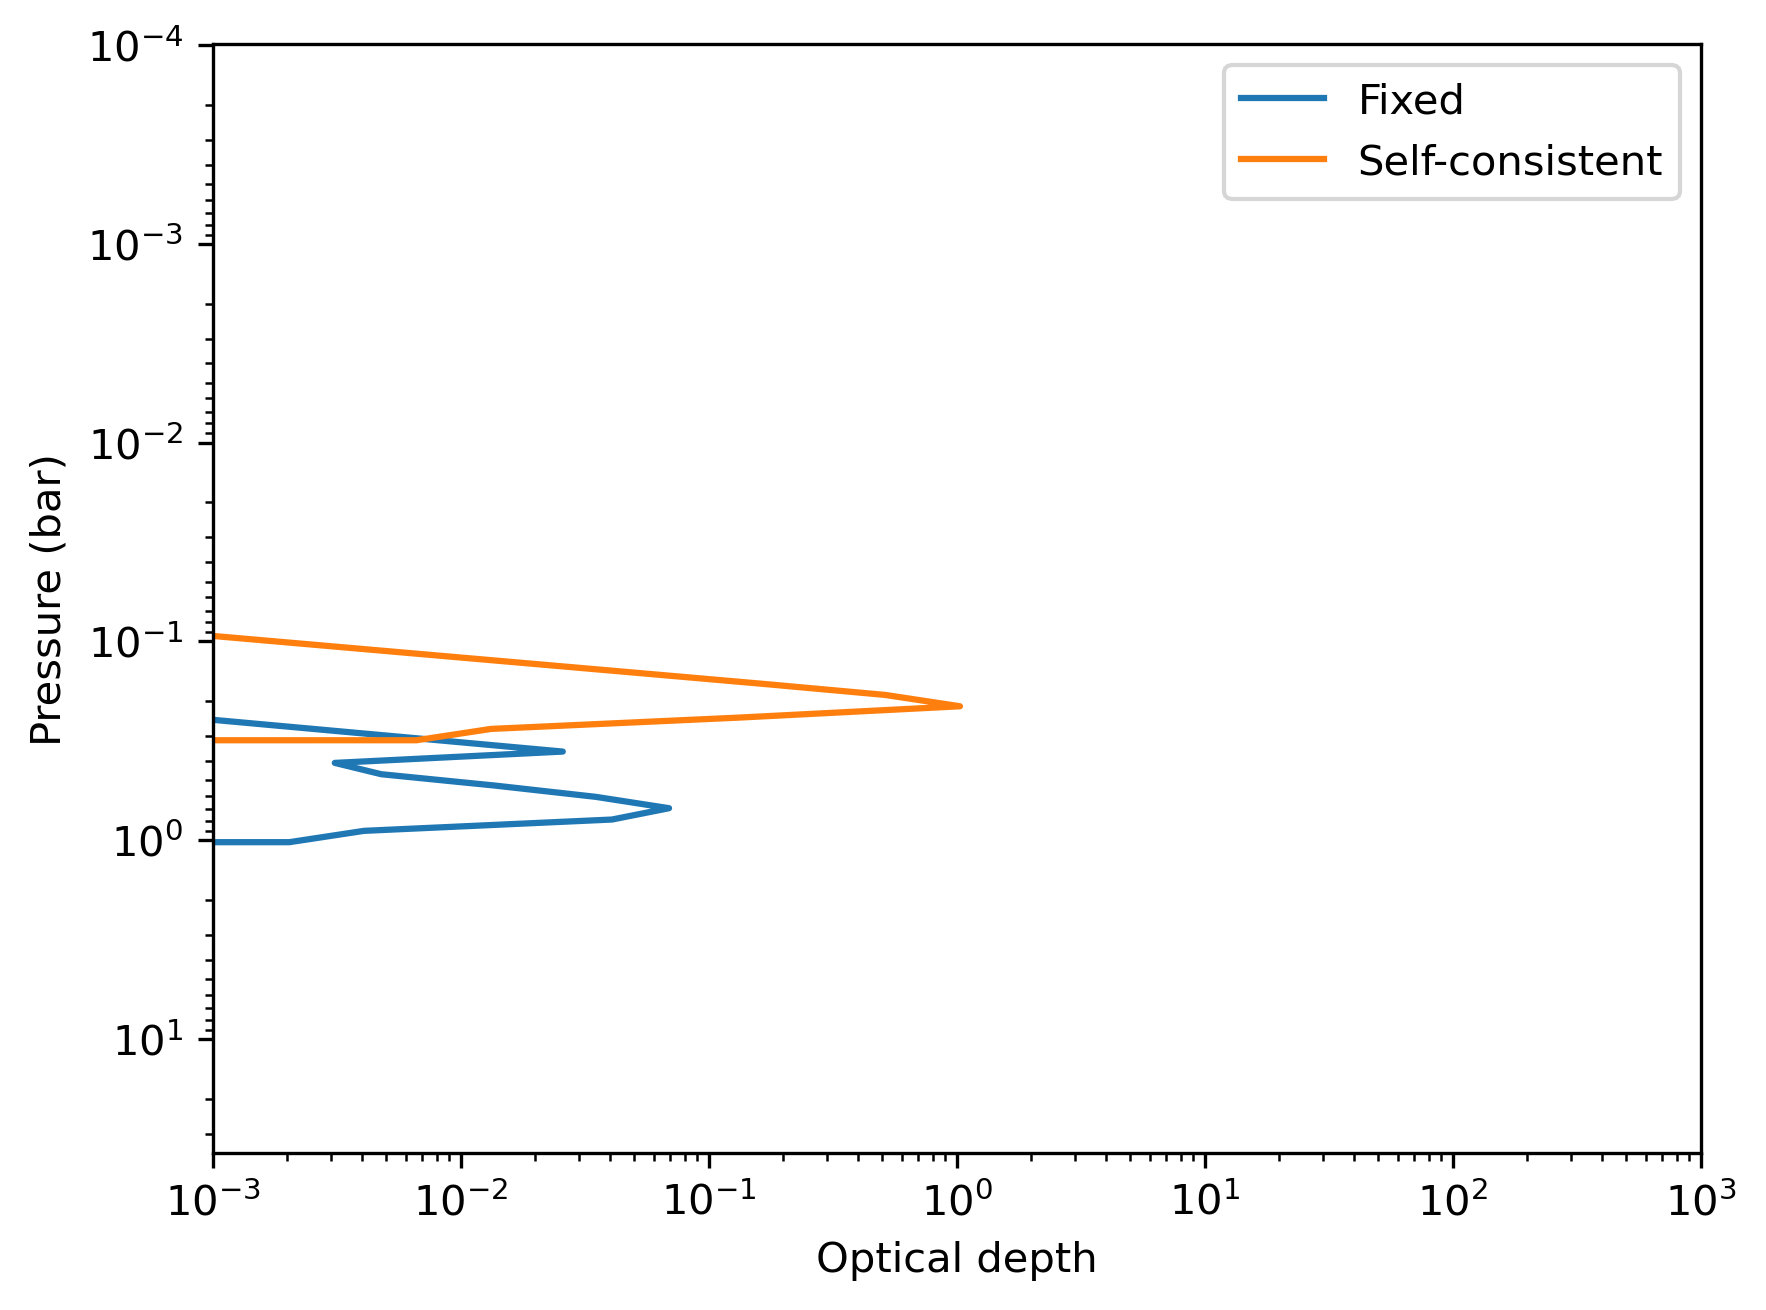

In [ ]:
# %%

opd_fixed = twod_to_threed(postproc_cld_out["opd_per_layer"])[:,150,0]
all_wavenumbers = np.unique(out_selfconsistent['cld_output_picaso'].wavenumber.values)
df_selfconsistent = out_selfconsistent['cld_output_picaso']
opd_selfconsistent = df_selfconsistent[df_selfconsistent.wavenumber == all_wavenumbers[150]].opd.values
plt.loglog(opd_fixed, out_selfconsistent["pressure"][:-1], label="Fixed")
plt.loglog(opd_selfconsistent, out_selfconsistent["pressure"][:-1], label="Self-consistent")
plt.legend()
plt.gca().invert_yaxis()
plt.xlim((1e-3, 1e3))
plt.xlabel("Optical depth")
plt.ylabel("Pressure (bar)")
plt.show()

In [ ]:
# %%

show(cldplt.pt(postproc_cld_out))

In [ ]:
# %%

wno

array([  714.63883991,   718.22098948,   721.8210947 ,   725.43924555,
         729.07553249,   732.73004644,   736.40287875,   740.09412125,
         743.80386622,   747.5322064 ,   751.27923501,   755.04504571,
         758.82973265,   762.63339046,   766.45611422,   770.29799951,
         774.15914236,   778.03963932,   781.93958738,   785.85908406,
         789.79822734,   793.7571157 ,   797.73584811,   801.73452404,
         805.75324346,   809.79210683,   813.85121514,   817.93066985,
         822.03057296,   826.15102696,   830.29213486,   834.4540002 ,
         838.63672702,   842.84041988,   847.06518389,   851.31112466,
         855.57834835,   859.86696162,   864.1770717 ,   868.50878635,
         872.86221385,   877.23746304,   881.63464331,   886.05386458,
         890.49523733,   894.95887261,   899.44488199,   903.95337764,
         908.48447227,   913.03827915,   917.61491212,   922.21448562,
         926.83711462,   931.48291469,   936.15200198,   940.84449322,
      

In [ ]:
# %%

1e4 / wno

array([13.99308216, 13.92329122, 13.85384838, 13.78475187, 13.71599999,
       13.64759102, 13.57952323, 13.51179494, 13.44440444, 13.37735005,
       13.3106301 , 13.24424292, 13.17818684, 13.11246023, 13.04706142,
       12.9819888 , 12.91724072, 12.85281558, 12.78871176, 12.72492767,
       12.66146169, 12.59831226, 12.53547778, 12.4729567 , 12.41074744,
       12.34884845, 12.28725818, 12.2259751 , 12.16499766, 12.10432436,
       12.04395366, 11.98388407, 11.92411407, 11.86464218, 11.80546691,
       11.74658678, 11.68800031, 11.62970604, 11.57170252, 11.51398829,
       11.45656192, 11.39942196, 11.34256699, 11.28599558, 11.22970633,
       11.17369782, 11.11796865, 11.06251743, 11.00734278, 10.95244332,
       10.89781767, 10.84346446, 10.78938234, 10.73556996, 10.68202597,
       10.62874904, 10.57573782, 10.522991  , 10.47050725, 10.41828527,
       10.36632375, 10.31462138, 10.26317689, 10.21198897, 10.16105636,
       10.11037778, 10.05995195, 10.00977763,  9.95985355,  9.91

In [ ]:
# %%

np.diff(1e4 / wno)

array([-0.06979093, -0.06944285, -0.0690965 , -0.06875188, -0.06840898,
       -0.06806779, -0.0677283 , -0.0673905 , -0.06705439, -0.06671995,
       -0.06638718, -0.06605607, -0.06572662, -0.0653988 , -0.06507263,
       -0.06474807, -0.06442514, -0.06410382, -0.0637841 , -0.06346597,
       -0.06314943, -0.06283448, -0.06252109, -0.06220926, -0.06189899,
       -0.06159027, -0.06128308, -0.06097743, -0.06067331, -0.0603707 ,
       -0.06006959, -0.05977   , -0.05947189, -0.05917527, -0.05888013,
       -0.05858647, -0.05829427, -0.05800352, -0.05771423, -0.05742638,
       -0.05713996, -0.05685497, -0.05657141, -0.05628925, -0.05600851,
       -0.05572917, -0.05545122, -0.05517465, -0.05489947, -0.05462565,
       -0.05435321, -0.05408212, -0.05381238, -0.05354399, -0.05327694,
       -0.05301122, -0.05274682, -0.05248375, -0.05222198, -0.05196152,
       -0.05170236, -0.0514445 , -0.05118791, -0.05093261, -0.05067859,
       -0.05042582, -0.05017432, -0.04992408, -0.04967508, -0.04

In [ ]:
# %%

np.diff(1e4 / wno) * fp[1:]

array([-2.73650158e-08, -2.56256190e-08, -2.73664381e-08, -2.58891740e-08,
       -2.77946192e-08, -2.72321385e-08, -2.73632902e-08, -2.54882875e-08,
       -2.87921964e-08, -2.63737352e-08, -2.67605200e-08, -2.86662677e-08,
       -2.81975428e-08, -2.75933990e-08, -2.88410126e-08, -2.87078860e-08,
       -2.91492214e-08, -2.81585999e-08, -2.88665235e-08, -2.92658984e-08,
       -2.87491899e-08, -2.82213665e-08, -2.90149324e-08, -2.93482978e-08,
       -3.00540597e-08, -2.98100042e-08, -3.00867229e-08, -3.07885094e-08,
       -2.98410819e-08, -3.08843794e-08, -3.04418222e-08, -3.02241364e-08,
       -3.07616954e-08, -3.04091704e-08, -2.95020976e-08, -3.15360744e-08,
       -3.06995868e-08, -3.07777183e-08, -3.18924586e-08, -3.12776307e-08,
       -3.28391139e-08, -3.18718290e-08, -3.19823756e-08, -3.21161402e-08,
       -3.20750611e-08, -3.23613709e-08, -3.15959081e-08, -3.14659779e-08,
       -3.13407055e-08, -3.25738596e-08, -3.25097681e-08, -3.28697246e-08,
       -3.29477301e-08, -

In [ ]:
# %%

np.sum(np.diff(1e4 / wno) * fp[1:])

-1.3338151653734153e-05

In [ ]:
# %%

np.sum(np.diff(1e4 / wno) * fp[1::-1])

ValueError: operands could not be broadcast together with shapes (768,) (2,) 

In [ ]:
# %%

np.sum(np.diff(1e4 / wno) * fp[1::-1])

ValueError: operands could not be broadcast together with shapes (768,) (2,) 

In [ ]:
# %%

np.sum(np.diff(1e4 / wno) * fp[1:len(fp):-1]

SyntaxError: incomplete input (<ipython-input-25-f5cb90436e4c>, line 2)

In [ ]:
# %%

np.sum(np.diff(1e4 / wno) * fp[1:len(fp):-1])

ValueError: operands could not be broadcast together with shapes (768,) (0,) 

In [ ]:
# %%

np.sum(np.diff(1e4 / wno) * fp[len(fp):-1:1])

ValueError: operands could not be broadcast together with shapes (768,) (0,) 

In [ ]:
# %%

np.sum(np.diff(1e4 / wno) * fp[len(fp):1:-1])

ValueError: operands could not be broadcast together with shapes (768,) (767,) 

In [ ]:
# %%

np.sum(np.diff(1e4 / wno) * fp[len(fp):0:-1])

-7.103645105768074e-06

In [ ]:
# %%

np.sum(np.diff(np.reverse(1e4 / wno)) * fp[len(fp):0:-1])

AttributeError: module 'numpy' has no attribute 'reverse'

In [ ]:
# %%

np.sum(np.diff(np.flip(1e4 / wno)) * fp[len(fp):0:-1])

1.3338151653734152e-05

In [ ]:
# %%

np.sum(np.diff(np.flip(1e4 / wno) / 1e4) * fp[len(fp):0:-1]) # erg/cm^2/s

1.3338151653734155e-09

In [ ]:
# %%

np.sum(np.diff(np.flip(1 / wno)) * fp[len(fp):0:-1]) # erg/cm^2/s

1.333815165373415e-09

In [ ]:
# %%

np.sum(np.diff(np.flip(1 / wno)) * fp[len(fp):0:-1]) / 5.67e-5 # erg/cm^2/s

2.3524076990712786e-05

In [ ]:
# %%

(np.sum(np.diff(np.flip(1 / wno)) * fp[len(fp):0:-1]) / 5.67e-5) ** (1/4)

0.06964310858683277

In [ ]:
# %%

(np.sum(np.diff(np.flip(1e8 / wno)) * fp[len(fp):0:-1]) / 5.67e-5) ** (1/4)

6.9643108586832785

In [ ]:
# %%

lam = np.flip(1 / wno) # cm, I think
fp_lam = np.flip(fp) # erg/cm^2/s/cm
(np.sum(np.diff(lam) * fp_lam[1:]) / 5.67e-5) ** (1/4)

0.06959068428231201

In [ ]:
lam

array([3.00759323e-05, 3.02266889e-05, 3.03782011e-05, 3.05304728e-05,
       3.06835078e-05, 3.08373098e-05, 3.09918828e-05, 3.11472306e-05,
       3.13033570e-05, 3.14602661e-05, 3.16179617e-05, 3.17764477e-05,
       3.19357281e-05, 3.20958070e-05, 3.22566882e-05, 3.24183759e-05,
       3.25808740e-05, 3.27441866e-05, 3.29083179e-05, 3.30732719e-05,
       3.32390527e-05, 3.34056645e-05, 3.35731114e-05, 3.37413977e-05,
       3.39105275e-05, 3.40805051e-05, 3.42513347e-05, 3.44230206e-05,
       3.45955670e-05, 3.47689784e-05, 3.49432590e-05, 3.51184132e-05,
       3.52944453e-05, 3.54713598e-05, 3.56491611e-05, 3.58278537e-05,
       3.60074419e-05, 3.61879303e-05, 3.63693235e-05, 3.65516259e-05,
       3.67348420e-05, 3.69189766e-05, 3.71040341e-05, 3.72900192e-05,
       3.74769366e-05, 3.76647909e-05, 3.78535869e-05, 3.80433292e-05,
       3.82340225e-05, 3.84256718e-05, 3.86182817e-05, 3.88118570e-05,
       3.90064027e-05, 3.92019235e-05, 3.93984243e-05, 3.95959102e-05,
      

In [ ]:
lam * 1e4

array([ 0.30075932,  0.30226689,  0.30378201,  0.30530473,  0.30683508,
        0.3083731 ,  0.30991883,  0.31147231,  0.31303357,  0.31460266,
        0.31617962,  0.31776448,  0.31935728,  0.32095807,  0.32256688,
        0.32418376,  0.32580874,  0.32744187,  0.32908318,  0.33073272,
        0.33239053,  0.33405664,  0.33573111,  0.33741398,  0.33910527,
        0.34080505,  0.34251335,  0.34423021,  0.34595567,  0.34768978,
        0.34943259,  0.35118413,  0.35294445,  0.3547136 ,  0.35649161,
        0.35827854,  0.36007442,  0.3618793 ,  0.36369323,  0.36551626,
        0.36734842,  0.36918977,  0.37104034,  0.37290019,  0.37476937,
        0.37664791,  0.37853587,  0.38043329,  0.38234023,  0.38425672,
        0.38618282,  0.38811857,  0.39006403,  0.39201923,  0.39398424,
        0.3959591 ,  0.39794386,  0.39993857,  0.40194327,  0.40395802,
        0.40598288,  0.40801788,  0.41006308,  0.41211853,  0.41418429,
        0.4162604 ,  0.41834692,  0.4204439 ,  0.42255139,  0.42

In [ ]:
# %%

lam = np.flip(1 / wno) # cm
fp_lam = np.flip(fp) # erg/cm^2/s/cm
(np.sum(np.diff(lam) * fp_lam[1:]) / 5.67e-5) ** (1/4)

0.06959068428231201

cloudless 0.06960032186055864
postprocessed 0.06897053235045146
fixed 0.06895248371942829
fixed100 0.06964304903003474
selfconsistent 0.06959068428231201


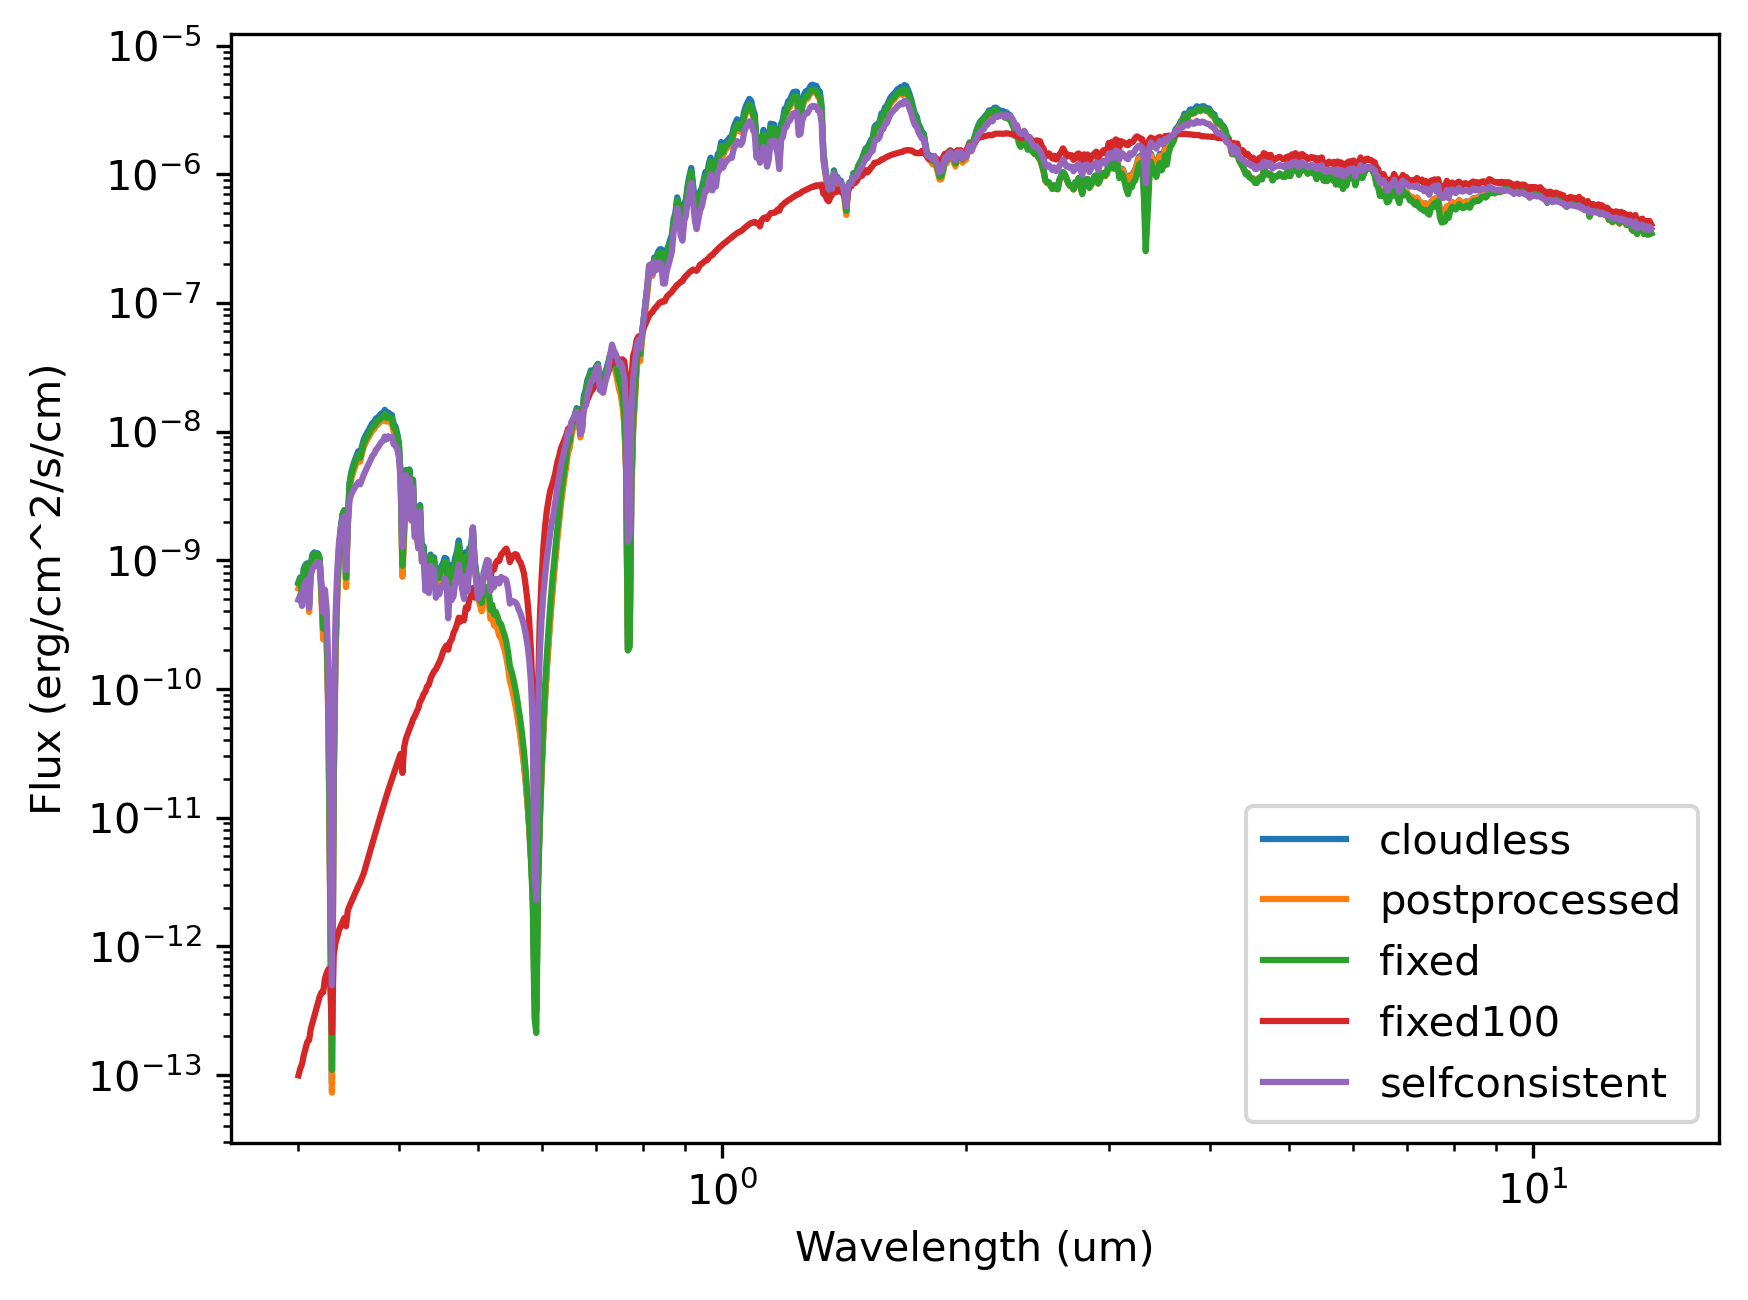

In [ ]:
# %%

plt.rcParams['figure.dpi'] = 300
for (out, cld_out, run_name) in zip(
    [out_cloudless, out_cloudless, out_fixed, out_fixed100, out_selfconsistent],
    [None, postproc_cld_df, postproc_cld_df, postproc_cld_df100, out_selfconsistent['cld_output_picaso']],
    ["cloudless", "postprocessed", "fixed", "fixed100", "selfconsistent"]
):
    wno, fp = calculate_spectrum(out, cld_out)
    plt.loglog(1e4/wno, fp, label=run_name)
    lam = np.flip(1 / wno) # cm
    fp_lam = np.flip(fp) # erg/cm^2/s/cm
    print(run_name, (np.sum(np.diff(lam) * fp_lam[1:]) / 5.67e-5) ** (1/4))
    np.save(f"../data/four_clouds_testing/wno_{run_name}.npy", wno)
    np.save(f"../data/four_clouds_testing/fp_{run_name}.npy", fp)

plt.xlabel("Wavelength (um)")
plt.ylabel("Flux (erg/cm^2/s/cm)")
plt.legend()
plt.show()